device : cuda
Loaded encoder "transfer_learning_best.pt" trained to step 1672501
Synthesizer using device: cuda


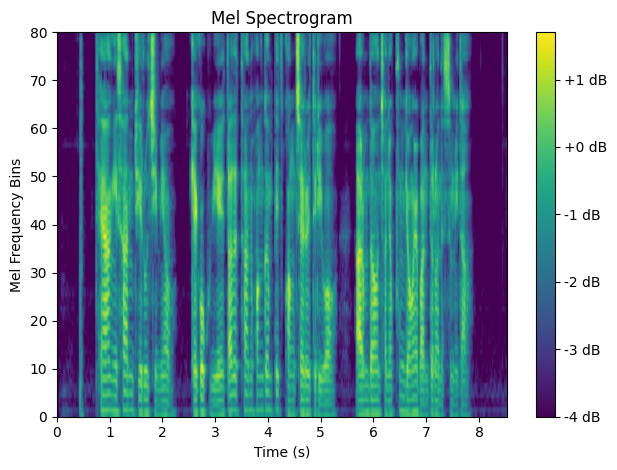

Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at C:\Users\admin\Desktop\Narrify\sv2tts_korean\vocoder\saved_models\transfer_learning.pt
Loaded vocoder "transfer_learning.pt" trained to step 1235000


In [33]:
import torch
from encoder import inference as encoder
from synthesizer.inference import Synthesizer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from toolbox.utterance import Utterance
import librosa
from synthesizer.hparams import hparams
from IPython.display import Audio, display

def plot_mel_spectrogram(mel_spectrogram, num_mels=80, hop_size=200, sample_rate=16000):
    # 시간 및 주파수 축 계산
    num_mels, num_frames = mel_spectrogram.shape
    time_bins = np.linspace(0, num_frames * (hop_size / sample_rate), num_frames)
    mel_bins = np.linspace(0, num_mels, num_mels)

    # 시각화
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', 
               cmap='viridis', 
               extent=[time_bins[0], time_bins[-1], mel_bins[0], mel_bins[-1]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency Bins')
    plt.tight_layout()
    plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device : {device}')
# texts = ["아내가 채식을 시작하기 전까지", "나는 그녀가 특별한 사람이라고 생각한 적이 없었다.", "솔직히 말하자면, 아내를 처음 만났을 때 끌리지도 않았다.",
#          "크지도 작지도 않은 키, 길지도 짧지도 않은 단발머리,", "각질이 일어난 노르스름한 피부, 외꺼풀 눈에 약간 튀어나온 광대뼈,",
#          "개성있어 보이는 것을 두려워하는 듯한 무채색의 옷차림."]
texts = ["보코더 컴에 배치사이즈 육십사로 신디 학습돌려줘"]

# encoder 준비
encoder_model_path = Path("C:/Users/admin/Desktop/Narrify/sv2tts_korean/encoder/saved_models/transfer_learning_best.pt")
enc = encoder.load_model(encoder_model_path, device)


# synthesizer 준비
# syn_model_path = Path("C:/Users/admin/Desktop/Narrify/sv2tts_korean/synthesizer/saved_models/balanced_samples_tranfer_learning_best/balanced_samples_tranfer_learning_best.pt")
syn_model_path = Path("C:/Users/admin/Desktop/Narrify/sv2tts_korean/synthesizer/saved_models/synthesizer_second/synthesizer_second_best_model.pt")
synthesizer = Synthesizer(syn_model_path, True)


# ref 준비, spec 만들기
fpath = Path("C:/Users/admin/Desktop/Narrify_data/test/hee/태양이산뒤로.wav")
wav = Synthesizer.load_preprocess_wav(fpath)
# wav = librosa.load(str(fpath), hparams.sample_rate)[0][int(hparams.sample_rate*1.7):]
# if hparams.rescale:
#     wav = wav / np.abs(wav).max() * hparams.rescaling_max
display(Audio(wav, rate=16000))
spec = synthesizer.make_spectrogram(wav) # ref spec
plot_mel_spectrogram(spec)


# vocoder 준비
from vocoder import inference as voc
vocoder_folder_path = Path("C:/Users/admin/Desktop/Narrify/sv2tts_korean/vocoder/saved_models")
vocoder_fpath = vocoder_folder_path.joinpath("transfer_learning.pt")
vocoder = voc.load_model(vocoder_fpath)


# embeds 추출
encoder_wav = encoder.preprocess_wav(wav)
embed, partial_embeds, _ = encoder.embed_utterance(encoder_wav, return_partials=True)
name = "cheolhee"
speaker_name = name
embeds = [embed] * len(texts)

[array([0.        , 0.01617089, 0.09272999, 0.        , 0.01741759,
       0.        , 0.0794129 , 0.00711639, 0.00712106, 0.        ,
       0.09532487, 0.07775768, 0.00293861, 0.        , 0.08078872,
       0.        , 0.05158208, 0.0269402 , 0.07238209, 0.        ,
       0.        , 0.00799189, 0.        , 0.        , 0.        ,
       0.06422019, 0.        , 0.04320367, 0.        , 0.        ,
       0.09064331, 0.05645418, 0.        , 0.        , 0.        ,
       0.0897784 , 0.04161223, 0.06340404, 0.00870908, 0.02545744,
       0.        , 0.00074452, 0.19829191, 0.05508269, 0.        ,
       0.        , 0.09445351, 0.04990649, 0.0029562 , 0.        ,
       0.        , 0.10903424, 0.13134442, 0.        , 0.        ,
       0.        , 0.03148624, 0.11656766, 0.        , 0.10708168,
       0.        , 0.        , 0.        , 0.03656661, 0.1123218 ,
       0.        , 0.13480479, 0.01427305, 0.        , 0.00128609,
       0.04387779, 0.1601867 , 0.0002983 , 0.0584656 , 0.0757

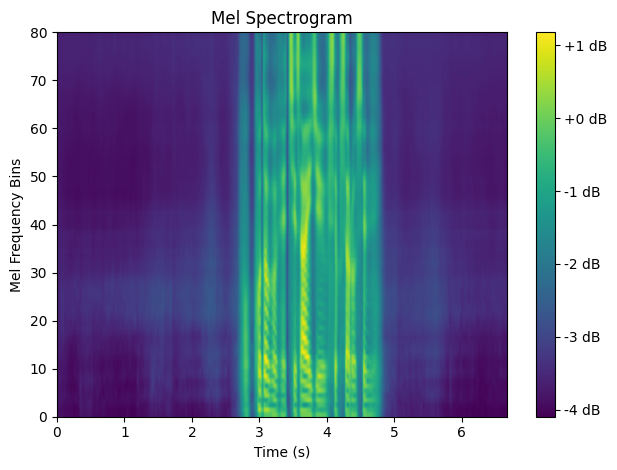

In [35]:
print(embeds)
# 합성
specs = synthesizer.synthesize_spectrograms(texts, embeds)
for spec in specs:
    plot_mel_spectrogram(spec)
breaks = [spec.shape[1] for spec in specs]
spec = np.concatenate(specs, axis=1)

In [15]:
for spec in specs:
    wav = voc.infer_waveform(spec)
    breaks = [spec.shape[1]]
    b_ends = np.cumsum(np.array(breaks) * Synthesizer.hparams.hop_size)
    b_starts = np.concatenate(([0], b_ends[:-1]))
    wavs = [wav[start:end] for start, end, in zip(b_starts, b_ends)]
    breaks = [np.zeros(int(0.15 * Synthesizer.sample_rate))] * len(breaks)
    wav = np.concatenate([i for w, b in zip(wavs, breaks) for i in (w, b)])

    # Trim excessive silences
    wav = encoder.preprocess_wav(wav)
    display(Audio(wav, rate=16000))

{| ████████████████ 437000/441600 | Batch Size: 46 | Gen Rate: 34.6kHz | }